# Star Trek Script Generator

**Vikrant Pulipati**\
**Computational Linguistics**\
**Spring 2024**\
**Rutgers University**

This is a simple neural network model that generates scripts for the 90s *Star Trek* shows, specifically *The Next Generation* and *Deep Space 9*. 

First, we import all the packages that we need. This code will run on the GPU if available, and on the CPU otherwise.

I recommend running this through Anaconda, as it comes with most of the required packages pre-installed. You will still need to install PyTorch, and you can do so by following the instructions on [this webpage](https://pytorch.org/get-started/locally/).

In [1]:
import os
import shutil

import math
import numpy as np
import torch
from torch import nn
from torch.nn.utils import rnn

from torch.utils import data
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

import random
import matplotlib.pyplot as plt

import torch.optim as optim

from tqdm.notebook import trange, tqdm

from collections import Counter

import regex as re

import torch.distributions as dist

import itertools

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print('Using device:', device)

Using device: cuda


## 1. Corpus

The data corpus for this model will consist of the scripts for every single episode of *Star Trek: The Next Generation* and *Star Trek: Deep Space 9*. Specifically, each script is stripped of any invalid characters, page numbers, or text that is not a part of the dialogue, story, or set directions. In addition, excess whitespace in between lines was also trimmed away. This was all done using regex. Finally, the scripts are assembled into one big text file to be processed into data batches.

In [2]:
# This is the code used to convert the individual scripts into a single corpus.
# Do not run this code, as the script files are not included alongside this notebook.

def getCorpus():
  scriptFolder = "Star Trek Scripts/"
  scripts = os.listdir(scriptFolder)
  print(f"# of Scripts: {len(scripts)}")

  corpus = ""
  alphabet = set([])
  print("Assembling Corpus")
  for script in tqdm(scripts):
    text = open(scriptFolder+script, 'rb').read().decode(encoding='utf-8')
    temp = re.findall(r"\n *TEASER *\n.*", text, flags = re.DOTALL)
    if len(temp) == 0: print(script)
    text = temp[0]
    text = re.sub(r"\n(.*?):(.*?) (- )?((REV\. )?)((FINAL )?)(\d*?\/\d*\/\.?\d*).*?\.?\s*?\n", "", text)
    text = re.sub(r"\n.*?OMITTED.*?\n", r"", text)
    text = re.sub(r"\n.*?CONTINUED.*?\n", r"", text)
    text = re.sub(r"(\n)\d+\w?(\s*?)", r"\1\2", text)
    text = re.sub(r"  +", r"\t", text)
    text = re.sub(r"\t\t+", r"\t\t", text)
    alphabet = alphabet | set(text)
    corpus += text.rstrip()+"\n"

  f = open('corpus.txt', 'w')
  f.write(corpus)
  f.close()
  return corpus, sorted(alphabet)

**Make sure corpus.txt is in the same directory as this notebook!!!!**

In [3]:
corpus = open('corpus.txt', 'rb').read().decode(encoding='utf-8')

print(corpus[:250])


	TEASER	

	FADE IN:

	EXT. SPACE - STARSHIP (OPTICAL)

	The U.S.S. Enterprise NCC 1701-D traveling at warp speed
	through space.

		PICARD V.O.
		Captain's log, stardate 42353.7.
		Our destination is planet Cygnus
		IV, beyond which lie


**Tokenization:** We want to isolate words from punctuation and whitepsace, but also capture some of the bizarre sci-fi names and words that come up in *Star Trek*.

In [4]:
def tokenize(string):
  return list(filter(lambda l: len(l) > 0, re.split("((?:\w\S*\w)| |\t|\r|\n|(?:\n\n+)|\.|!|,|\(|\))", string)))

# Corpus is included already prepared alongside this notebook
wordCorpus = tokenize(corpus)
print(f"Tokenized Corpus:\n{wordCorpus[:100]}")
uniqueWords = set(wordCorpus)
numUniqueWords = len(uniqueWords)
print()
print(f"Length of Word Corpus: {len(wordCorpus)}")
print(f"# of Unique Words: {len(uniqueWords)}")

Tokenized Corpus:
['\r', '\n', '\t', 'TEASER', '\t', '\r', '\n', '\r', '\n', '\t', 'FADE', ' ', 'IN', ':', '\r', '\n', '\r', '\n', '\t', 'EXT', '.', ' ', 'SPACE', ' ', '-', ' ', 'STARSHIP', ' ', '(', 'OPTICAL', ')', '\r', '\n', '\r', '\n', '\t', 'The', ' ', 'U.S.S', '.', ' ', 'Enterprise', ' ', 'NCC', ' ', '1701-D', ' ', 'traveling', ' ', 'at', ' ', 'warp', ' ', 'speed', '\r', '\n', '\t', 'through', ' ', 'space', '.', '\r', '\n', '\r', '\n', '\t', '\t', 'PICARD', ' ', 'V.O', '.', '\r', '\n', '\t', '\t', "Captain's", ' ', 'log', ',', ' ', 'stardate', ' ', '42353.7', '.', '\r', '\n', '\t', '\t', 'Our', ' ', 'destination', ' ', 'is', ' ', 'planet', ' ', 'Cygnus', '\r', '\n', '\t']

Length of Word Corpus: 9947627
# of Unique Words: 56478


We are immediately faced with a problem, which is that we have too many possible tokens. In order to make a neural network that trains before the heat death of the universe, we must shrink our dictionary. We can use Counter to rank the tokens by frequency and eliminate the least used tokens. In this case, we remove tokens used fewer than 10 times.

In [5]:
counter = Counter(wordCorpus)

print(counter.most_common()[:100])

[(' ', 2601384), ('\t', 1298545), ('\r', 1005057), ('\n', 1005057), ('.', 519134), ('the', 127234), (',', 121368), ('to', 96161), ('a', 68112), ('and', 53974), (')', 53913), ('(', 53895), ('I', 45300), ('of', 45055), ('you', 38935), ('is', 37514), ('?', 34088), ('in', 30505), ('it', 25731), ('his', 22204), ('on', 22066), ('that', 21453), ('at', 20712), ('for', 19016), ('with', 18894), ('as', 18563), ('The', 18163), ('--', 16129), ('have', 14977), ('her', 14768), ('PICARD', 14758), ('be', 14662), ('he', 14549), ('this', 14504), ('are', 14489), ('him', 14221), ('not', 12396), ('we', 12258), ('INT', 12179), ('me', 11488), ('-', 10788), ('from', 10119), ('Picard', 10088), ('He', 9998), ('SISKO', 9996), ('up', 9783), ('but', 9672), ('out', 9638), ('your', 9539), ('was', 9360), ('beat', 9287), ('RIKER', 8780), ('what', 8702), (':', 8570), ('You', 8552), ('do', 8550), ('Worf', 8533), ("I'm", 8440), ('all', 8320), ('an', 8279), ('OPTICAL', 8043), ('my', 7828), ('about', 7702), ('can', 7653), (

In [6]:
wordsToIgnore = set()
for word, freq in counter.items():
  if freq < 10: wordsToIgnore.add(word)
    
dictionary = uniqueWords - wordsToIgnore

print(f"Dictionary Size: {len(dictionary)}")

Dictionary Size: 13793


With this much more manageable dictionary, we create mappings from token to index, and vice versa.

In [7]:
wordToIndex = {u:i for i,u in enumerate(dictionary)}
indexToWord = np.array(list(dictionary))

## 2. Training Data

**Input:** Input sequences will consist of the corpus, sliced into sequences of 100

**Expected Output:** The output sequence will be the input sequence, but shifted one token to the right.
   - The last token in the output sequence is the "next token" that we want to predict based on the input sequence
    
**Caveat:** We need to exclude rare tokens. Since these tokens are typically meaningful words, we cannot simply remove them from the data without breaking the grammar and meaning of the scripts. Therefore, the best solution is to simply drop the sequences that include rare tokens. While this shrinks our dataset, it makes it much cleaner and more usable.

In [8]:
def getWordsAsIndices(seq):
  return [wordToIndex[word] for word in seq]

def getWordDatasets(corpus, wordsToIgnore, sequence_length):
  batchedCorpus = list(batched(corpus, sequence_length+1))
  print(f"Total # of Sequences: {len(batchedCorpus)}")
  filteredBatches = list(filter(lambda sequence: not (set(sequence) & wordsToIgnore), batchedCorpus))
  print(f"After Removing Rare Tokens: {len(filteredBatches)}")
  fullData = list(map(getWordsAsIndices, filteredBatches))
  fullData = list(map(splitChunk, fullData))
  if (len(fullData[-1][0]) != sequence_length): fullData = fullData[:-1]
  random.shuffle(fullData)
  splitPoint = int(3/4*len(fullData))
  fullTrainingData = fullData[:splitPoint] # 2/3 of data for training
  fullTestingData = fullData[splitPoint:] # 1/3 of data for testing
  
  return StarTrekDataset(fullTrainingData), StarTrekDataset(fullTestingData)

In [9]:
def batched(iterable, n):
  if n < 1: raise ValueError('n must be at least one')
  it = iter(iterable)
  while batch := tuple(itertools.islice(it, n)):
    yield batch
        
def splitChunk(chunk):
  return chunk[:-1], chunk[1:]

class StarTrekDataset(data.Dataset):
  def __init__(self, dataset):
    self.dataset = torch.tensor(dataset).to(torch.long).to(device)

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    return self.dataset[idx]
  
def getDatasets(corpus, sequence_length):
  fullData = list(map(splitChunk, batched(corpus, sequence_length+1)))
  if (len(fullData[-1][0]) != sequence_length): fullData = fullData[:-1]
  random.shuffle(fullData)
  splitPoint = int(3/4*len(fullData))
  fullTrainingData = fullData[:splitPoint] # 2/3 of data for training
  fullTestingData = fullData[splitPoint:] # 1/3 of data for testing
  
  return StarTrekDataset(fullTrainingData), StarTrekDataset(fullTestingData)

In [10]:
trainingWordData, testingWordData = getWordDatasets(wordCorpus, wordsToIgnore, 100)
trainingWordDataLoader = data.DataLoader(trainingWordData, batch_size=64, shuffle=True, drop_last = True)
testingWordDataLoader = data.DataLoader(testingWordData, batch_size=64, shuffle=True, drop_last = True)
print(f"# of Batches in Training Loader: {len(trainingWordDataLoader)}")
print(f"# of Batches in Testing Loader: {len(testingWordDataLoader)}")

Total # of Sequences: 98492
After Removing Rare Tokens: 43190
# of Batches in Training Loader: 506
# of Batches in Testing Loader: 168


## 3. Model Architecture

Generating text token-by-token can be thought of as an iteratively applied classification problem. In other words, each input sequence is being classified according to what the next token in the sequence is. All the model needs to do is to take in an input sequence and return a vector of probabilities, where each component is the probability of the next token being the corresponding character.

To this end, my model was constructed as follows:

In [11]:
class StarTrekWordScriptGenerator(nn.Module):
  def __init__(self, dictionarySize = 4834):
    super(StarTrekWordScriptGenerator, self).__init__()
    
    self.embedding = nn.Embedding(dictionarySize, 1024)
    
    self.lstm = nn.LSTM(1024, 2048, 2, batch_first = True)
    
    self.linearLayers = nn.Sequential(
      nn.Linear(2048, 1024), nn.LayerNorm(1024), nn.ReLU(),
      nn.Linear(1024, 512), nn.LayerNorm(512), nn.ReLU(),
      nn.Linear(512, dictionarySize)
    )
    
    self.to(device)
    
  def forward(self, X, states = None):
    embedded = self.embedding(X)
    if states:
      h0, c0 = states
      output_sequence, (ht, ct) = self.lstm(embedded, (h0, c0))
    else:
      output_sequence, (ht, ct) = self.lstm(embedded)
    logits = self.linearLayers(output_sequence)
    return logits, (ht, ct)

First, each input token is converted into a 1024-D embedding vector. Then, that embedded sequence is passed to a 2-Layer LSTM. The LSTM processes each element in the sequence and generates a 2048-D output sequence, where each element in the output sequence is a "summary" of the sequence up to that point. This summary is then passed to a series of dense linear layers which compute the probability distribution of the next character in the sequence.

## 4. Training

**If you wish to skip straight to generating scripts, jump ahead to Section 5.** \
This model will take at least 45 minutes to train for semi-decent results on the provided data.

In [12]:
def trainWordLevelGenerator(model, epochs = 10, lr = 0.001, weight_decay = 0.001):
  optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

  trainingLosses = []
  testingLosses = []
  for epoch in trange(epochs):
    model.train()
    trainingLoss = 0
    #Training Loop
    for data in tqdm(trainingWordDataLoader, total=len(trainingWordDataLoader)):
      optimizer.zero_grad()
      X, y = torch.permute(data, (1, 0, 2))
      y_pred, _ = model(X)
      loss = nn.CrossEntropyLoss()(torch.permute(y_pred, (0, 2, 1)), y.to(torch.long))
      trainingLoss += loss.item()
      loss.backward()
      optimizer.step()
    trainingLosses.append(trainingLoss/len(trainingWordDataLoader))
      
    model.eval()
    testingLoss = 0
    #Evaluation Loop
    with torch.no_grad():
      for data in tqdm(testingWordDataLoader, total=len(testingWordDataLoader)):
        X, y = torch.permute(data, (1, 0, 2))
        y_pred, _ = model(X)
        loss = nn.CrossEntropyLoss()(torch.permute(y_pred, (0, 2, 1)), y.to(torch.long))
        testingLoss += loss.item()
    testingLosses.append(testingLoss/len(testingWordDataLoader))
    
  return model, trainingLosses, testingLosses

def plotResults(trainLoss, testLoss):
  plt.figure()
  plt.title("Loss over Training Time")
  plt.xlabel("Training Epoch")
  plt.ylabel("Loss")
  plt.plot(range(len(trainLoss)), trainLoss, label="Train")
  plt.plot(range(len(testLoss)), testLoss, label="Test")
  plt.legend()
  plt.show()

In [13]:
wordLevelModel = StarTrekWordScriptGenerator(len(dictionary))
print(wordLevelModel)

StarTrekWordScriptGenerator(
  (embedding): Embedding(13793, 1024)
  (lstm): LSTM(1024, 2048, num_layers=2, batch_first=True)
  (linearLayers): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=13793, bias=True)
  )
)


In [14]:
wordLevelModel, trainLoss, testLoss = trainWordLevelGenerator(wordLevelModel, epochs = 25)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

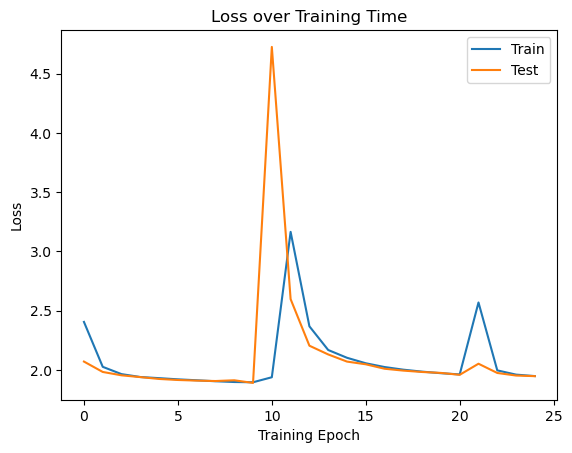

In [15]:
plotResults(trainLoss, testLoss)

## 5. Text Generation

**If you skipped Section 4, uncomment and run the code below.**

**Make sure WordLevelScriptGen.pt is in the same directory as this notebook!!!!**

In [17]:
#wordLevelModel = StarTrekWordScriptGenerator(len(dictionary))
#wordLevelModel.load_state_dict(torch.load('WordLevelScriptGen.pt'))

The function below takes an input prompt and passes it to the network to receive the next token. It does this in a loop until a sequence of the desired length has been generated.

The temperature parameter determines how "risky" the generation algorithm is by changing how flat the probability distribution is. For high temperature values, the probability distribution becomes flat, meaning that it becomes more likely to generate sequences with less likely token. With low temperature values, the generator will be more "conservative", only picking the most likely next tokens and creating outputs that are more grammatical, but also more boring.

In [18]:
def generateTextByWord(model, prompt, length, temperature = 0.7):

  model_input = torch.tensor([getWordsAsIndices(tokenize(prompt))]).to(device)

  generated_text = []
  
  for i in tqdm(range(length)):
    if i == 0: logits, (ht, ct) = model(model_input)
    else: logits, (ht, ct) = model(model_input, (ht, ct))
    tempLogits = logits[0,-1,:] / temperature
    next_word_index = dist.Categorical(logits = tempLogits).sample()

    generated_text.append(indexToWord[next_word_index])
    model_input = torch.tensor([[next_word_index]]).to(device)

  return (prompt + ''.join(generated_text))

In [22]:
print(generateTextByWord(wordLevelModel, "\n\t\tTEASER\n", 500, .5))

  0%|          | 0/500 [00:00<?, ?it/s]


		TEASER

	INT. ENGINEERING

	Odo reacts to the table.

		RIKER
		(to O'Brien's console)
		I could keep the Dominion to 
		the "
 
		(beat.)
		(beat)
		I'll see me up the Dominion will 
		be a bad heart, I don't 
		be a little like to you.

		KASIDY
		(a beat)
		I don't think I thought you may 
		say to you get to ask you to 
		find you to do you do your mind.	
		I don't have to be the ship 
		in the Enterprise of the Cardassian
		Federation in the bridge 
		when I have to be a little 
		that the Klingon ship is the
		very be out of the changeling...

		DATA
		But I don't you do you 
		be the bridge in a few 
		wall.

		DATA
		(smiles)
		I am not not my job to be
		her quarters.

		DATA
		(to Odo)
		I don't think I'm just not the 
		time to get the time.

		SISKO
		I am right with the ship.

		SISKO
		(continuing)
		I don't think you want to be 
		to do that


As you can see, the Word-Level generation model captures the structure and cadence of the scripts. Characters not only talk, but they talk to others, as the model is able to place set directions and other non-dialogue text in a way that looks organic. The only drawback is that the sentences themselves are largely word salad. However, this is unavoidable given the simplicity of my model architecture and the small amount of data being used. If I had way more data and a much larger model, I could generate more grammatical and sensible sentences because the model would have room to encode much more detailed linguistic information about each word and its place in each sequence.